In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import meq

In [3]:
import torch
import pyro
from pyro.infer import MCMC, NUTS, Predictive
import pyro.distributions as dist
import arviz as az

In [4]:
#experiments = 10
kb = np.random.gamma(4., 1.)
ub = np.random.lognormal(1., .5)
b0 = np.random.beta(7., 1.)
#b1 = np.random.beta(1., 10.)
IB0 = np.random.gamma(40., 1.)

In [5]:
def single_prev_inc(params, eir):
    p = meq.default_parameters()
    (
        p.kb,
        p.ub,
        p.IB0
    ) = params
    p.EIR = eir
    solution = meq.solve(p)
    prop = np.array(solution.prop)
    return (
        np.array(solution.pos_M)[3:10].sum() / np.array(solution.prop)[3:10].sum(),
        np.array(solution.pos_M)[10:30].sum() / np.array(solution.prop)[10:30].sum(),
        np.array(solution.pos_M)[30:].sum() / np.array(solution.prop)[30:].sum(),
        np.array(solution.inc)[:5].sum() / np.array(solution.prop)[:5].sum(),
        np.array(solution.inc)[5:15].sum() / np.array(solution.prop)[5:15].sum(),
        np.array(solution.inc)[15:].sum() / np.array(solution.prop)[15:].sum()
    )

In [6]:
population = 100_000
EIR = 21.

In [7]:
observations = [round(v * population) for v in single_prev_inc([kb, ub, IB0], EIR)]

In [8]:
observations

[57188, 35192, 20137, 416, 211, 59]

In [9]:
def model():
    kb = pyro.sample('kb', dist.Gamma(4., 1.))
    ub = pyro.sample('ub', dist.LogNormal(1., .5))
    IB0 = pyro.sample('IB0', dist.Gamma(40., 1.))
    #b0 = pyro.sample('b0', dist.Beta(7., 1.))
    
    # Is this compatible with autograd? Give me the gradient
    pred_prev = single_prev_inc([
        kb,
        ub,
        IB0
        #b0
    ], EIR)
    pyro.sample(
        'obs_prev',
        dist.Independent(
            dist.Binomial(torch.as_tensor(population), torch.as_tensor(pred_prev)),
            1
        )
    )

In [10]:
prior = Predictive(model, num_samples=100)()

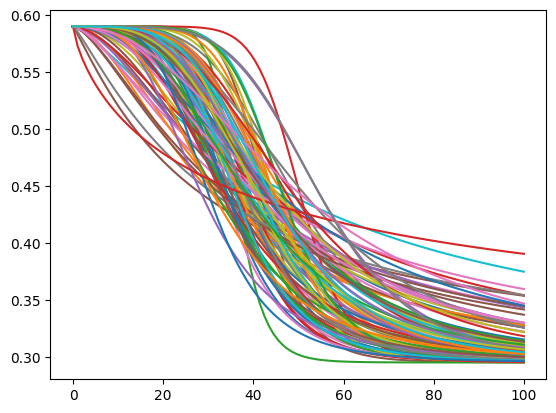

In [11]:
IB = np.linspace(0, 100, num=100)
b0, b1, IB0, kb = meq.default_parameters().b0, meq.default_parameters().b1, prior['IB0'], prior['kb']
b = b0*(b1 + (1-b1)/(1+(IB[:, np.newaxis]/IB0)**kb))
plot = plt.plot(IB, b)
plt.xlabel('Bites')
plt.ylabel('Immunity')

In [12]:
conditioned = pyro.condition(
    model,
    data={
        'obs_prev': torch.as_tensor(observations)
    }
)

In [13]:
n_samples = 200
n_warmup = 200
n_chains = 4

nuts_kernel = NUTS(conditioned, jit_compile=False)
mcmc = MCMC(
    nuts_kernel,
    num_samples=n_samples,
    warmup_steps=n_warmup,
    num_chains=n_chains,
)
mcmc.run()
mcmc.summary(prob=0.7)

Warmup [1]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/400 [00:00, ?it/s]


                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     46.00      2.46     45.99     43.48     48.12     26.70      1.19
        kb      4.07      1.42      4.07      2.33      5.43     13.56      1.21
        ub      3.58      1.71      3.39      1.66      5.07     14.37      1.28

Number of divergences: 0


In [21]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(conditioned, posterior_samples)()

In [22]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


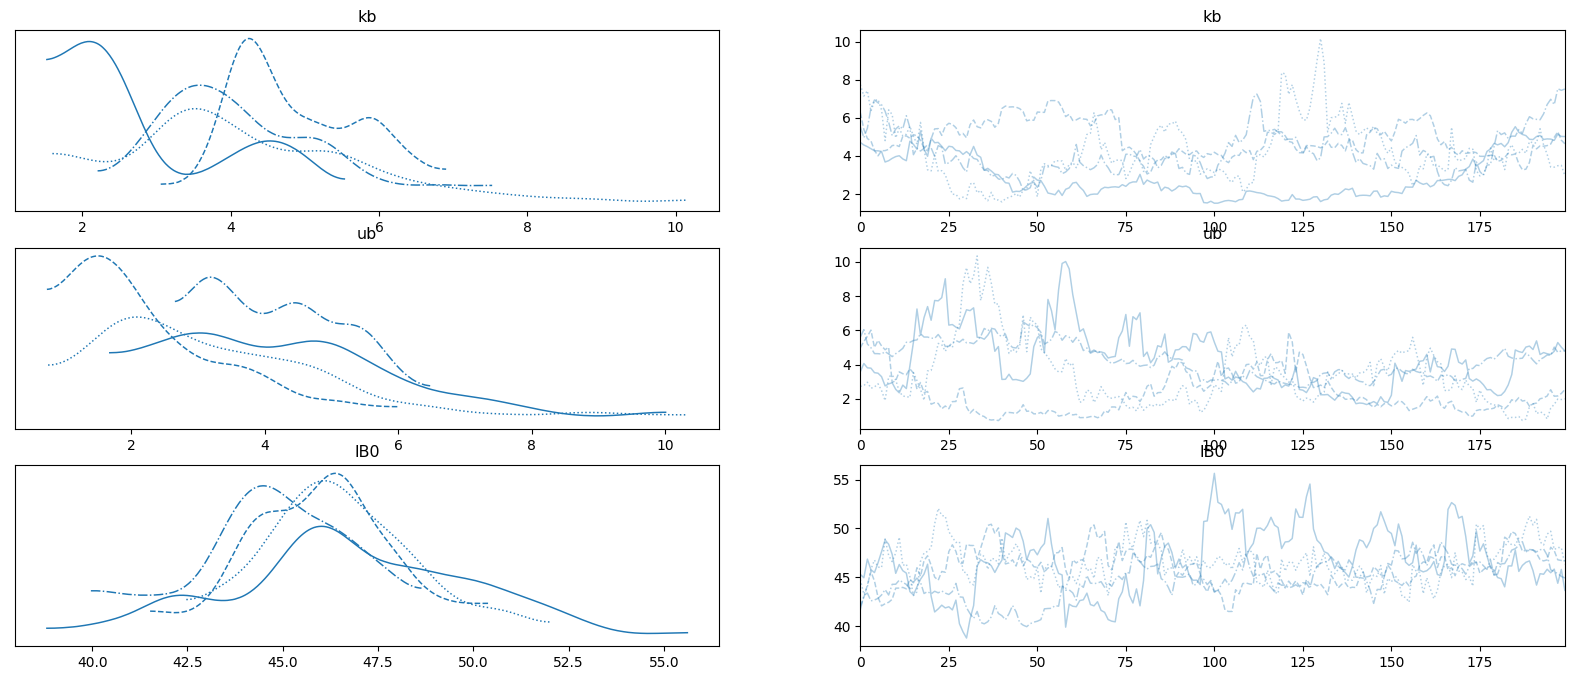

In [23]:
axs = az.plot_trace(pyro_data, var_names=['kb', 'ub', 'IB0'], figsize=(20, 8))